DDPG code adapted from 
https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

In [1]:
import random
from collections import deque
from matplotlib import pyplot as plt
import numpy as np
# from sympy import EmptySequence
import torch 
import torch.nn as nn
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
from environment import * 
import ddpg_utils
from networks import *
from ddpg import *


%load_ext autoreload
%autoreload 2

## Environment

From the formula $$ M \dot x_t  + D x_t = u_t$$ and the forward Euler discretisation $\dot x \approx \frac{x_{t+1} - x_t}{T_s}$ derived the formula to obtain $x_{t+1}$ on the basis of $x_t$ and $u_t$: $$x_{t+1} = \frac{T_s}{M}u_t + (1 - \frac{D T_s}{M})x_t$$

In [2]:
env = BasicEnvironment(m = 0.5)


At timestep 1 step reward is [-0.54932081] and total reward [-0.54932081]
At timestep 2 step reward is [-0.43945665] and total reward [-0.49438873]
At timestep 3 step reward is [-0.35156532] and total reward [-0.45044307]
At timestep 4 step reward is [-0.28125226] and total reward [-0.41528654]
At timestep 5 step reward is [-0.22500181] and total reward [-0.38716131]
At timestep 6 step reward is [-0.18000144] and total reward [-0.36466113]
At timestep 7 step reward is [-0.14400116] and total reward [-0.34666098]
At timestep 8 step reward is [-0.11520092] and total reward [-0.33226087]
At timestep 9 step reward is [-0.09216074] and total reward [-0.32074078]
At timestep 10 step reward is [-0.07372859] and total reward [-0.3115247]
At timestep 11 step reward is [-0.05898287] and total reward [-0.30415184]
At timestep 12 step reward is [-0.0471863] and total reward [-0.29825356]
At timestep 13 step reward is [-0.03774904] and total reward [-0.29353493]
At timestep 14 step reward is [-0.03

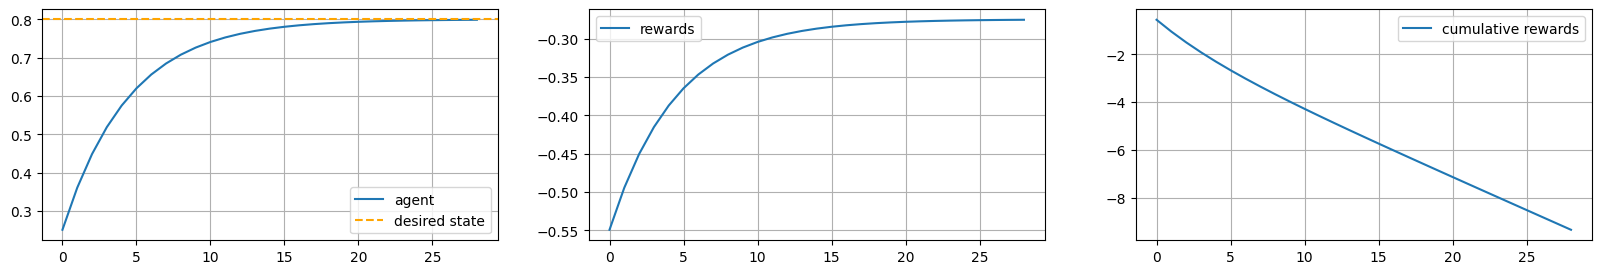

In [3]:
env.reset()
# actions = np.random.rand(100000,1)
actions = np.ones((100000,1))*0.8
states = []
rewards = []
cum_rewards = []
state, done = env.reset()

for i, action in enumerate(actions): 
    state, reward, done = env.step(action=action)
    if done : 
        print(f"Problem solved at timestep {i} with {env.cur_state} and {state}")
        break
    states.append(state)
    rewards.append(reward)
    if i == 0 : 
        cum_rewards.append(reward)
    else: 
        cum_rewards.append(cum_rewards[-1] + reward)

f, ax = plt.subplots(1,3,figsize = (20,3))   
ax[0].plot(range(len(states)), states)
ax[0].axhline(y = env.desired_state, xmax=len(states)-1, color = 'orange', linestyle = '--')
ax[0].grid()
ax[0].legend(['agent', 'desired state'])
ax[1].plot(rewards)
ax[1].legend(['rewards'])
ax[1].grid()
ax[2].plot(cum_rewards)
ax[2].legend(['cumulative rewards'])
ax[2].grid()


## Training

episode: 0 terminated after 60 steps, last state 0.11485838558159216, reward: -121.23, average reward: -121.2343770333435
episode: 1 terminated after 60 steps, last state -0.4159475373380998, reward: -174.94, average reward: -148.0877914656252
episode: 2 terminated after 60 steps, last state -0.5067848097059442, reward: -206.01, average reward: -167.3949600545058
episode: 3 terminated after 60 steps, last state -0.9930420122615917, reward: -304.52, average reward: -201.67575266205807
episode: 4 terminated after 60 steps, last state -0.9963774323617175, reward: -326.37, average reward: -226.6137227945397
episode: 5 terminated after 60 steps, last state -0.9901019230208905, reward: -323.53, average reward: -267.07300184130395
episode: 6 terminated after 60 steps, last state -0.9959515413006532, reward: -236.01, average reward: -279.2861004566714
episode: 7 terminated after 60 steps, last state -0.9978722190083842, reward: -251.0, average reward: -288.28521558709343
episode: 8 terminated 

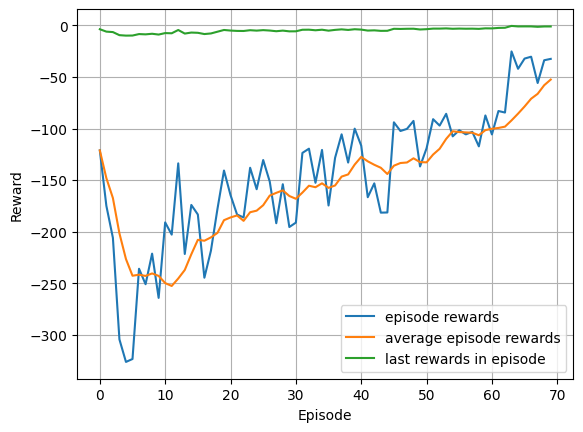

In [14]:
import sys
env = BasicEnvironment(m = 0.5, max_episode_len=60)
agent = DDPGAgent(env)
batch_size = 128
rewards = []
avg_rewards = []
last_rewards = []

for episode in range(70):
    state, done = env.reset()
    state = np.array(state, dtype=float)
    episode_reward = 0
    t = 0
    while not done:
        action = agent.get_action(state)
        new_state, reward, done = env.step(action) 
        if done : 
            break
        new_state = np.array(new_state, dtype=float)
        action = np.array([action], dtype=float)
        reward = np.array(reward, dtype = float)
        agent.memory.append((state, action, reward, new_state, done))
        # print(f"At timestep {t}: state {state[0]}, action {action[0]}, reward {reward[0]}", end = '\r')
        agent.memory.append((state, action, reward, new_state, done))
        
        if len(agent.memory) > batch_size:
            # print(agent.memory.sample_batch(batch_size))
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward[0]
        t+= 1

    last_rewards.append(reward[0])
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))
    # print('\n')
    # print(rewards)
    sys.stdout.write("episode: {} terminated after {} steps, last state {}, reward: {}, average reward: {}\n".format(episode,t, state[0], np.round(episode_reward, decimals=2), np.mean(rewards[-5:])))
    
    

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot(last_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['episode rewards', 'average episode rewards', 'last rewards in episode'])
plt.grid()
plt.show()

In [12]:
import pickle
import os 
models_path = 'models'
os.makedirs(models_path)
torch.save(agent.actor, os.path.join(models_path, 'actor.pth'))
torch.save(agent.actor_target, os.path.join(models_path,'actor-target.pth'))
torch.save(agent.critic, os.path.join(models_path,'critic.pth'))
torch.save(agent.critic_target, os.path.join(models_path,'critic-target.pth'))

## Testing the agent on the same environment

In [10]:
env = BasicEnvironment(m = 0.5)
state, _ = env.reset()
print(state)

env = BasicEnvironment(m=0.5, start_state=0.0)
state, _ = env.reset()
print(state)

[0.01605015]
[0.]


Problem solved at timestep 30 with [0.80333865] and [0.80333865]


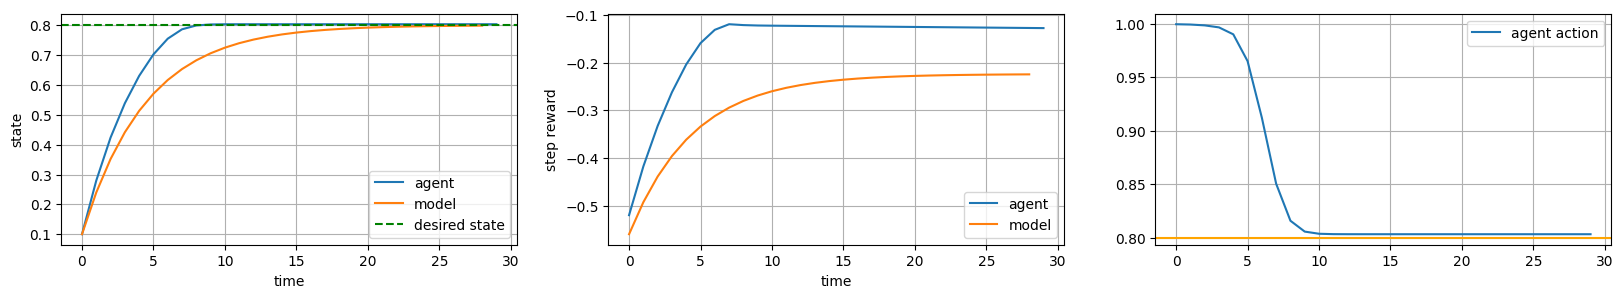

In [5]:
states = []
rewards = []
cum_rewards = []
actions = []
start_state = 0.1
env = BasicEnvironment(m = 0.5, start_state=start_state)
state, done = env.reset()
i = 0
while not done: 
    action = agent.get_action(state)
    next_state, reward, done = env.step(action=action)
    if done : 
        print(f"Problem solved at timestep {i} with {env.cur_state} and {next_state}")
        break
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    if i == 0 : 
        cum_rewards.append(reward)
    else: 
        cum_rewards.append(cum_rewards[-1] + reward)
    i+=1
    state = next_state

states_model = []
rewards_model = []
cum_rewards_model = []
env = BasicEnvironment(m = 0.5, start_state=start_state)
state, done = env.reset()
i = 0
while not done: 
    action = 0.8
    next_state, reward, done = env.step(action=action)
    if done : 
        break
    states_model.append(state)
    rewards_model.append(reward)
    if i == 0 : 
        cum_rewards_model.append(reward)
    else: 
        cum_rewards_model.append(cum_rewards[-1] + reward)
    i+=1
    state = next_state
    
f, ax = plt.subplots(1,3,figsize = (20,3))   
ax[0].plot(states)
ax[0].plot(states_model)
ax[0].axhline(y = env.desired_state, xmax=len(states)-1, color = 'green', linestyle = '--')
ax[0].grid()
ax[0].legend(['agent', 'model','desired state'])
ax[0].set_xlabel('time')
ax[0].set_ylabel('state')
ax[1].plot(rewards)
ax[1].plot(rewards_model)
ax[1].legend(['agent', 'model'])
ax[1].set_xlabel('time')
ax[1].set_ylabel('step reward')
ax[1].grid()
# ax[2].plot(cum_rewards)
# ax[2].plot(cum_rewards_model)
# ax[2].legend(['agent', 'model'])
# ax[2].set_xlabel('time')
# ax[2].set_ylabel('cumulative reward')
# ax[2].grid()
ax[2].plot(actions)
ax[2].legend(['agent action'])
ax[2].axhline(y = env.desired_state, xmax=len(states_model)-1, color = 'orange')
ax[2].grid()


## Environment with added delay

Problem solved at timestep 30 with [0.80317599] and [0.80317599]


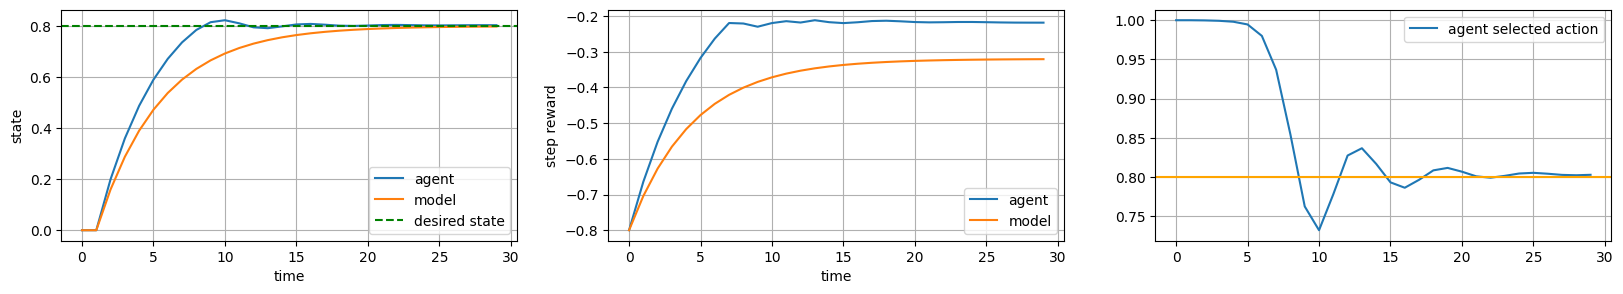

In [8]:
delay = 1
delayed_env = DelayedEnvironment(m = 0.5, start_state=0.0, delay=delay, max_episode_len=30*delay)
######################## Simulation of the agent #####################################
states = []
rewards = []
cum_rewards = []
actions = []
state, done = delayed_env.reset()
i = 0
while not done: 
    action = agent.get_action(state)
    # if delayed_env.timestep < delayed_env.delay : 
    #     actions.append(0)
    # else : 
    #     actions.append(delayed_env.actions_queue[0])
    next_state, reward, done = delayed_env.step(action=action)
    if done : 
        print(f"Problem solved at timestep {i} with {delayed_env.cur_state} and {next_state}")
        break
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    if i == 0 : 
        cum_rewards.append(reward)
    else: 
        cum_rewards.append(cum_rewards[-1] + reward)
    i+=1
    state = next_state
######################## Simulation with a step function #############################
states_model = []
rewards_model = []
cum_rewards_model = []
state, done = delayed_env.reset()
i = 0
while not done: 
    action = 0.8
    next_state, reward, done = delayed_env.step(action=action)
    if done : 
        break
    states_model.append(state)
    rewards_model.append(reward)
    if i == 0 : 
        cum_rewards_model.append(reward)
    else: 
        cum_rewards_model.append(cum_rewards[-1] + reward)
    i+=1
    state = next_state

f, ax = plt.subplots(1,3,figsize = (20,3))   
ax[0].plot(states)
ax[0].plot(states_model)
ax[0].axhline(y = delayed_env.desired_state, xmax=len(states)-1, color = 'green', linestyle = '--')
ax[0].grid()
ax[0].legend(['agent', 'model','desired state'])
ax[0].set_xlabel('time')
ax[0].set_ylabel('state')
ax[1].plot(rewards)
ax[1].plot(rewards_model)
ax[1].legend(['agent', 'model'])
ax[1].set_xlabel('time')
ax[1].set_ylabel('step reward')
ax[1].grid()
ax[2].plot(actions)
ax[2].legend(['agent selected action'])
ax[2].axhline(y = env.desired_state, xmax=len(states_model)-1, color = 'orange')
ax[2].grid()
